In [1]:
# visualization.ipynb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as osp

# Load the saved results
models = ['MLP', 'GraphSAGE', 'PointNet', 'GUNet']
task = 'scarce'


Diagnostics for model: MLP
Full true length: 100000, pred length: 100000
MAE:        0.054757
RMSE:       0.196859
R²:         0.966921
Bias (µ e): -0.000532
Pearson r:  0.983381
Spearman ρ: 0.994865
[Baseline mean] MAE: 0.621963 | RMSE: 1.082377 | ΔRMSE: +0.885518


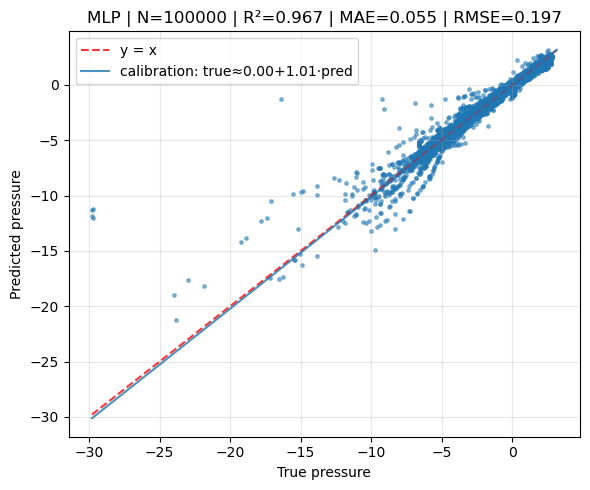

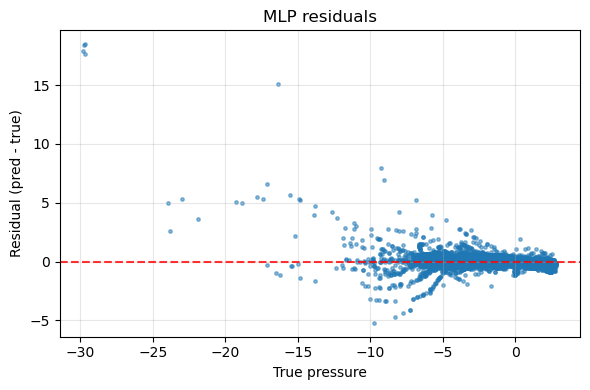


Diagnostics for model: GraphSAGE
Full true length: 100000, pred length: 100000
MAE:        0.057612
RMSE:       0.198998
R²:         0.966056
Bias (µ e): 0.003138
Pearson r:  0.983327
Spearman ρ: 0.993544
[Baseline mean] MAE: 0.619983 | RMSE: 1.080106 | ΔRMSE: +0.881107


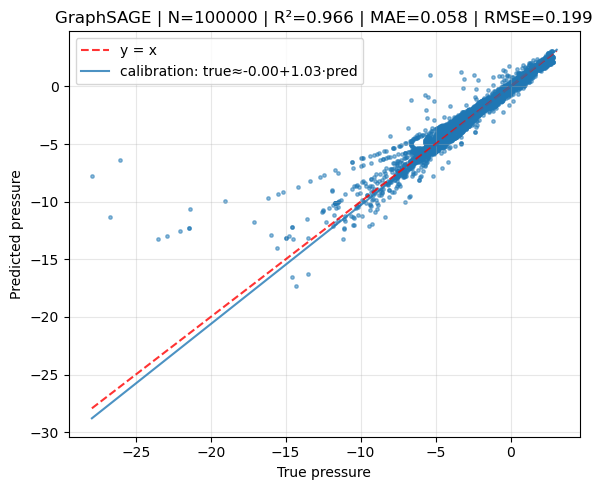

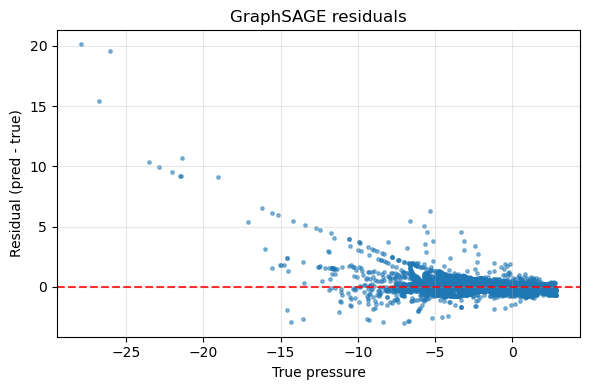


Diagnostics for model: PointNet
Full true length: 100000, pred length: 100000
MAE:        0.055731
RMSE:       0.170613
R²:         0.974871
Bias (µ e): 0.001896
Pearson r:  0.987481
Spearman ρ: 0.991486
[Baseline mean] MAE: 0.620094 | RMSE: 1.076268 | ΔRMSE: +0.905655


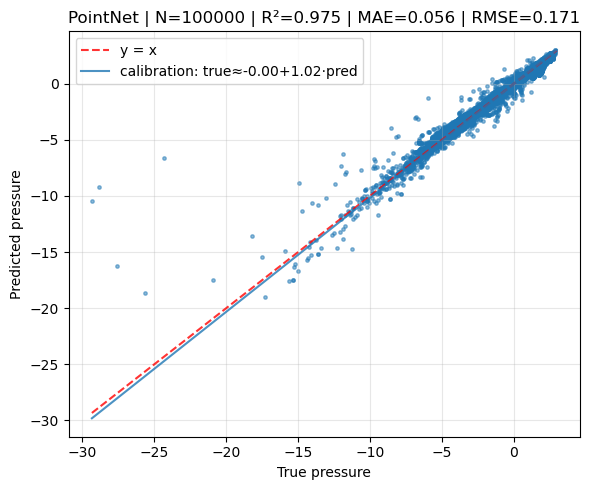

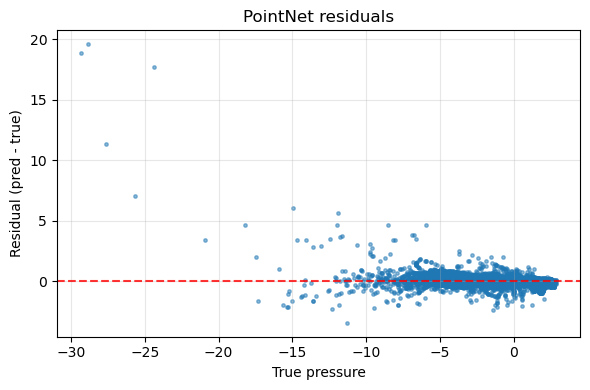


Diagnostics for model: GUNet
Full true length: 100000, pred length: 100000
MAE:        0.058575
RMSE:       0.179262
R²:         0.973960
Bias (µ e): 0.009965
Pearson r:  0.987977
Spearman ρ: 0.993751
[Baseline mean] MAE: 0.632986 | RMSE: 1.110881 | ΔRMSE: +0.931619


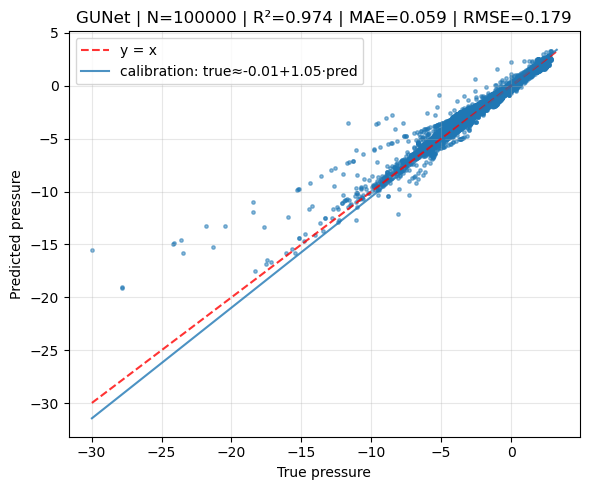

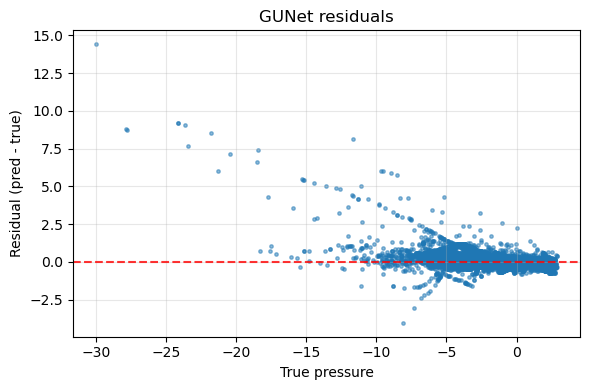

In [2]:
# --- Diagnostics: alignment check + compact, high-value metrics ---
# What you get for each model:
# - MAE / RMSE: scale of errors (RMSE penalizes big misses)
# - Pearson r / Spearman ρ: linear + rank agreement
# - R²: variance explained (vs. predicting the mean)
# - Mean bias: systematic over/under prediction
# - Plots: parity (with y=x) + residuals vs true to spot bias/heteroscedasticity
#
# Notes:
# - Keeps your length-mismatch guard, but also filters NaNs/Infs.
# - (Optional) compares against a simple mean baseline.

import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

SHOW_BASELINE = True  # set False to hide the mean-predictor baseline comparison

for model in models:
    print("\n" + "="*80)
    print(f"Diagnostics for model: {model}")

    # --- Load & flatten ---
    true_coefs = np.load(osp.join('scores', task, model, 'true_coefs.npy')).flatten()
    pred_mean  = np.load(osp.join('scores', task, model, 'pred_coefs_mean.npy')).flatten()

    print(f"Full true length: {len(true_coefs)}, pred length: {len(pred_mean)}")

    # --- Errors & core metrics ---
    errors = pred_mean - true_coefs
    mae  = np.mean(np.abs(errors))
    mse  = np.mean(errors**2)
    rmse = np.sqrt(mse)

    # Correlations (linear + rank)
    pear,  _ = pearsonr(true_coefs, pred_mean) 
    spear, _ = spearmanr(true_coefs, pred_mean) 

    # Variance explained
    r2 = r2_score(true_coefs, pred_mean)

    # Systematic shift (positive => overprediction on average)
    bias = np.mean(errors)

    print(f"MAE:        {mae:.6f}")
    print(f"RMSE:       {rmse:.6f}")
    print(f"R²:         {r2:.6f}")
    print(f"Bias (µ e): {bias:.6f}")
    print(f"Pearson r:  {pear:.6f}")
    print(f"Spearman ρ: {spear:.6f}")

    # --- Optional: compare to a trivial baseline (predict the mean of true) ---
    if SHOW_BASELINE:
        base_pred = np.full_like(true_coefs, fill_value=true_coefs.mean())
        base_rmse = np.sqrt(np.mean((base_pred - true_coefs)**2))
        base_mae  = np.mean(np.abs(base_pred - true_coefs))
        print(f"[Baseline mean] MAE: {base_mae:.6f} | RMSE: {base_rmse:.6f} | "
              f"ΔRMSE: {base_rmse - rmse:+.6f}")

    # --- Parity plot (Pred vs True) ---
    plt.figure(figsize=(6, 5))
    plt.scatter(true_coefs, pred_mean, s=6, alpha=0.5)
    minv = min(true_coefs.min(), pred_mean.min())
    maxv = max(true_coefs.max(), pred_mean.max())
    plt.plot([minv, maxv], [minv, maxv], linestyle='--', color='r', alpha=0.8, label='y = x')

    # Add a simple calibration fit (true ≈ a + b*pred) to spot scale/offset issues
    # (computed in a numerically stable way via np.polyfit)
    b, a = np.polyfit(pred_mean, true_coefs, deg=1)  # true ≈ a + b*pred
    xx = np.linspace(minv, maxv, 100)
    plt.plot(xx, a + b*xx, alpha=0.8, label=f'calibration: true≈{a:.2f}+{b:.2f}·pred')

    plt.xlabel("True pressure")
    plt.ylabel("Predicted pressure")
    plt.title(f"{model} | N={len(true_coefs)} | R²={r2:.3f} | MAE={mae:.3f} | RMSE={rmse:.3f}")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # --- Residual plot (Residual = pred - true) ---
    # A flat band around 0 is good. Slope or funnel shape suggests bias or heteroscedasticity.
    plt.figure(figsize=(6, 4))
    plt.scatter(true_coefs, errors, s=6, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--', alpha=0.8)
    plt.xlabel("True pressure")
    plt.ylabel("Residual (pred - true)")
    plt.title(f"{model} residuals")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


100%|██████████| 200/200 [01:00<00:00,  3.30it/s]


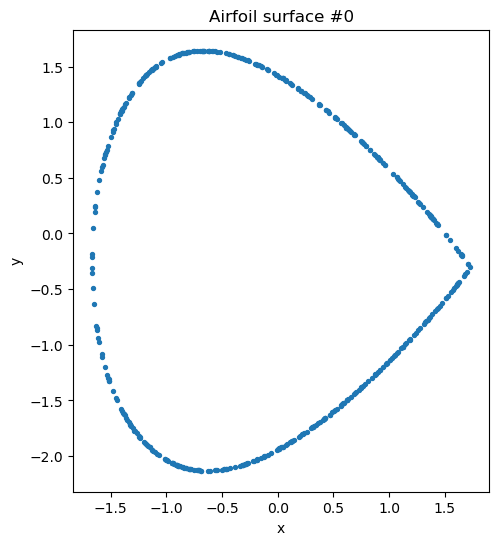

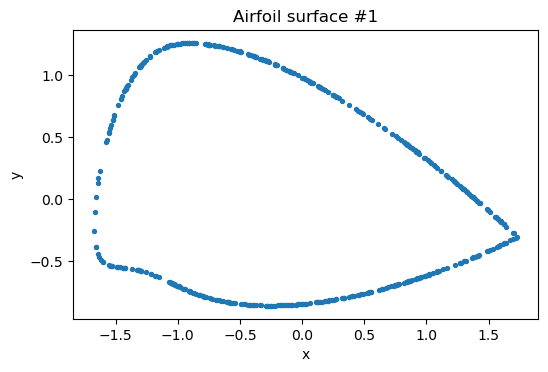

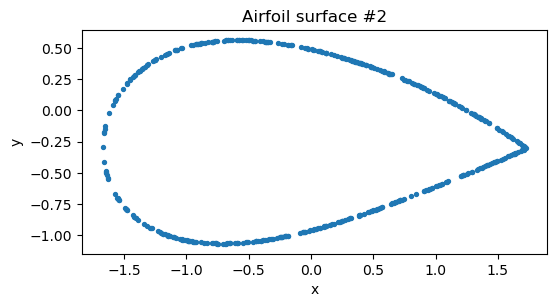

In [3]:
import os.path as osp
import json
import numpy as np
import matplotlib.pyplot as plt

from dataset import Dataset

# ---- load manifest and datasets ----
path_in = 'Dataset'
with open(osp.join(path_in, 'manifest.json'), 'r') as f:
    manifest = json.load(f)

manifest_train = manifest['scarce' + '_train']
n = int(.1 * len(manifest_train))
train_dataset_files = manifest_train[:-n]
test_files          = manifest['full_test']

# We keep normalization from training
train_dataset, coef_norm = Dataset(train_dataset_files,
                                   norm=True,
                                   sample='uniform',
                                   surf_ratio=1)
test_dataset = Dataset(test_files,
                       sample='uniform',
                       coef_norm=coef_norm,
                       surf_ratio=1)

# ---- Plot the first 3 test foils ----
num_to_show = min(3, len(test_dataset))

for i in range(num_to_show):
    pts = test_dataset[i].x[:, :2]     # take first two columns (x,y)
    plt.figure(figsize=(6, 6))
    plt.scatter(pts[:, 0], pts[:, 1], s=8)
    plt.gca().set_aspect('equal', 'box')
    plt.title(f"Airfoil surface #{i}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


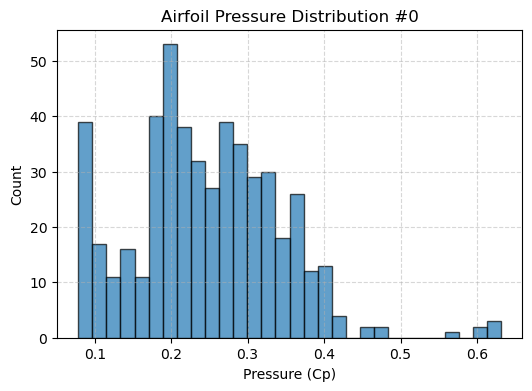

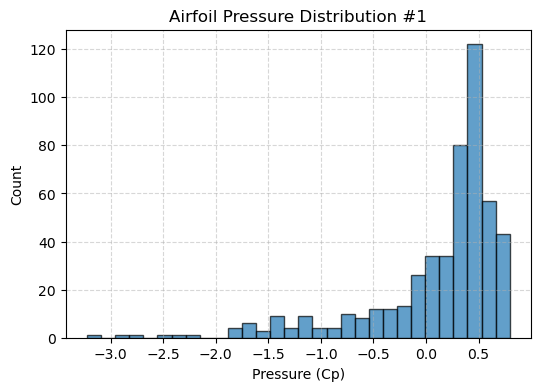

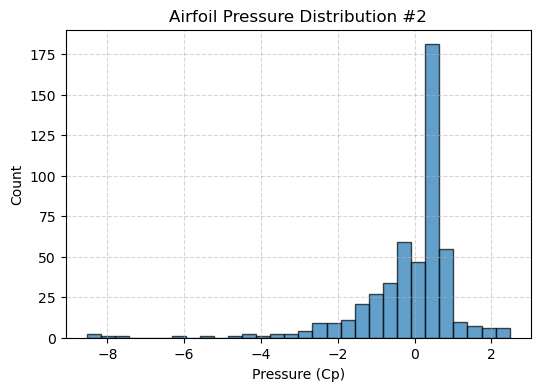

In [4]:
import matplotlib.pyplot as plt


num_to_show = min(3, len(test_dataset))

for i in range(num_to_show):
    pts_real = test_dataset[i].y  # pressure or Cp
    pts = test_dataset[i].x       # coordinates (not used for histogram)

    plt.figure(figsize=(6, 4))
    plt.hist(pts_real, bins=30, edgecolor='black', alpha=0.7)
    plt.title(f"Airfoil Pressure Distribution #{i}")
    plt.xlabel("Pressure (Cp)")
    plt.ylabel("Count")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()



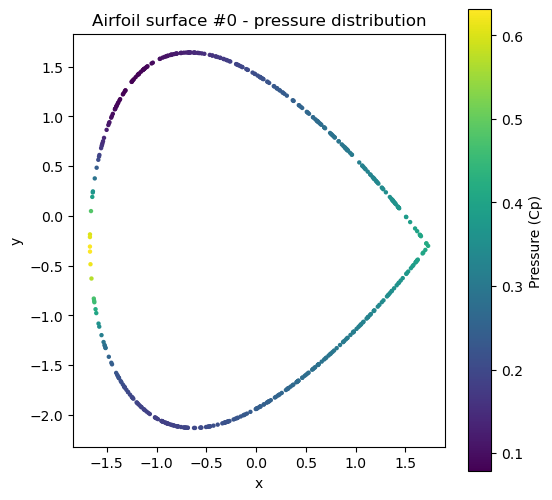

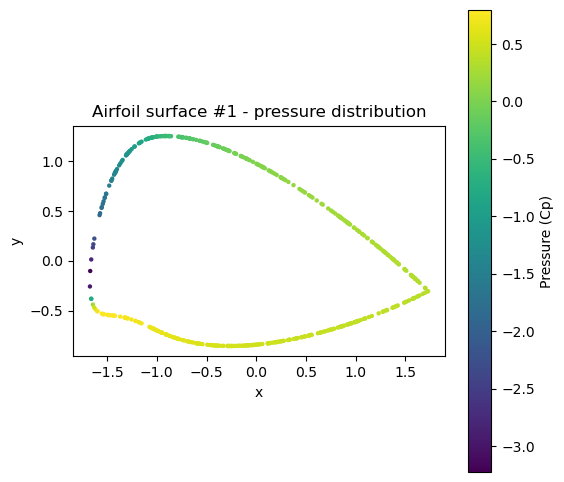

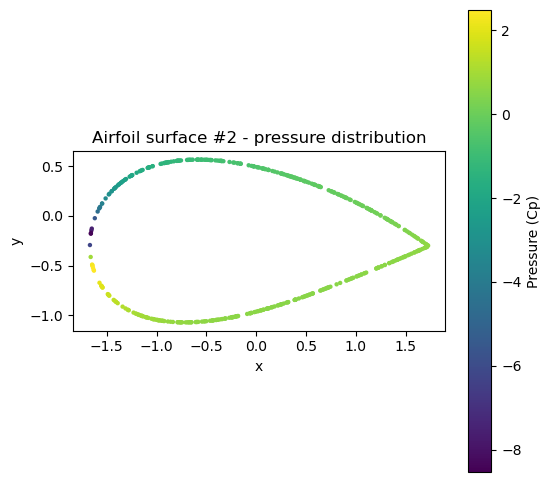

In [5]:

# ---- Plot the first 3 test foils ----
num_to_show = min(3, len(test_dataset))

for i in range(num_to_show):
    pts = test_dataset[i].x[:, :2]       # (x, y) coordinates
    pressure = test_dataset[i].y         # pressure or Cp values

    plt.figure(figsize=(6, 6))
    sc = plt.scatter(pts[:, 0], pts[:, 1],
                     c=pressure,
                     cmap='viridis',      # good colormap for pressure
                     s=10,
                     edgecolor='none')
    plt.gca().set_aspect('equal', 'box')
    plt.colorbar(sc, label='Pressure (Cp)')
    plt.title(f"Airfoil surface #{i} - pressure distribution")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

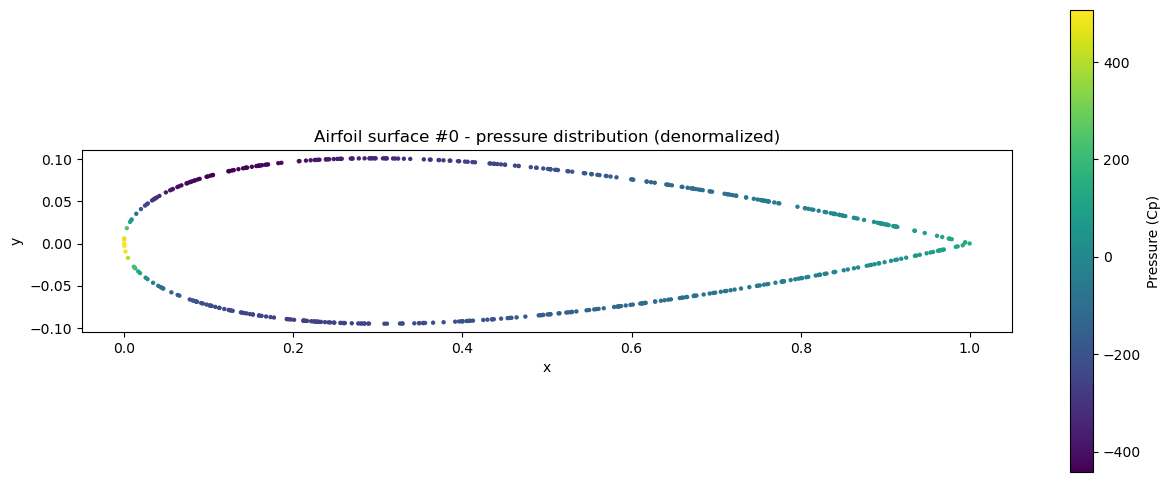

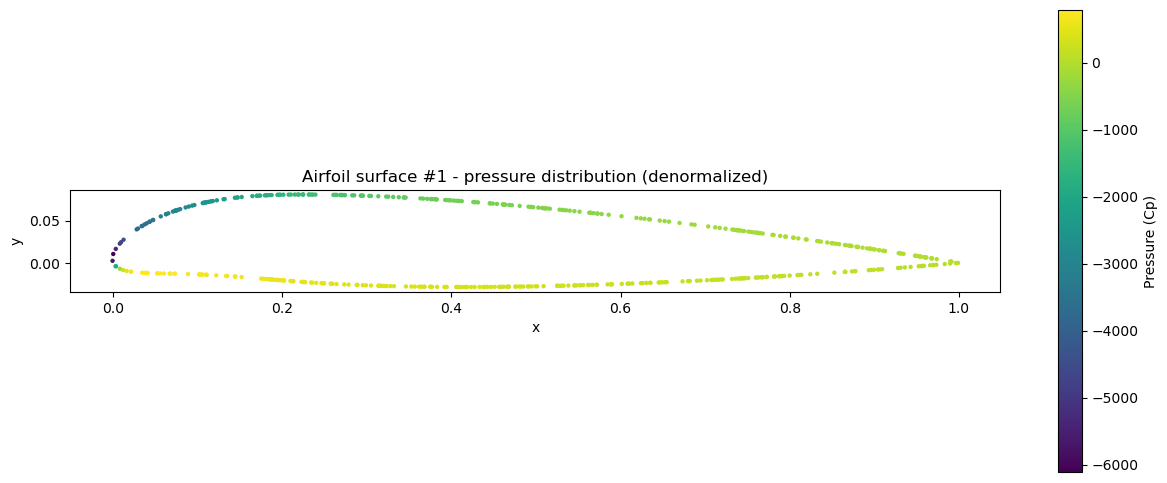

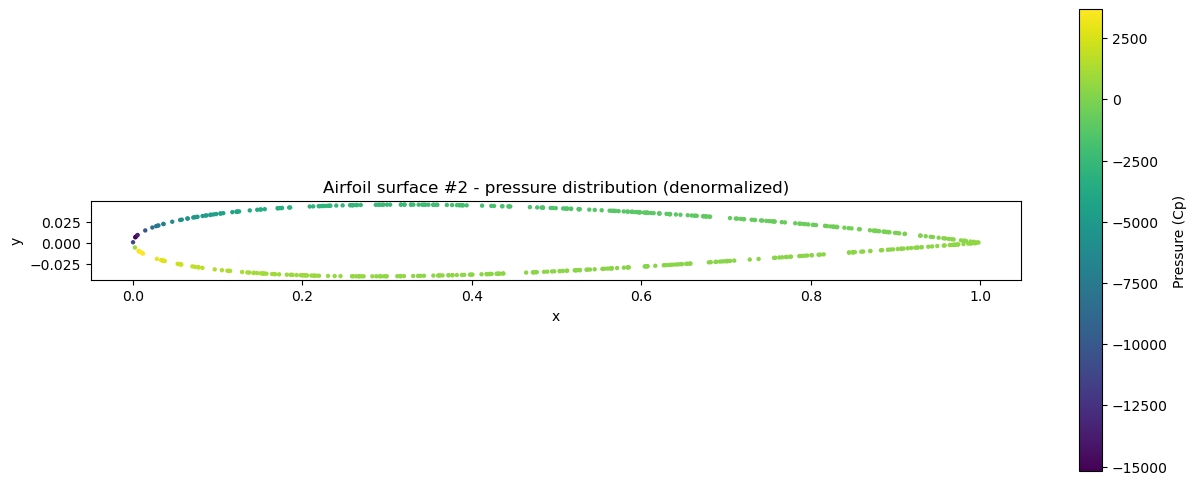

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def to_numpy(a):
    # Safely convert Torch tensors or arrays to NumPy
    try:
        import torch
        if isinstance(a, torch.Tensor):
            return a.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(a)

# unpack normalization parameters (mu_x, std_x, mu_y, std_y)
mu_x, std_x, mu_y, std_y = coef_norm

num_to_show = min(3, len(test_dataset))
pressure_idx = 0  # change if pressure is another column in y

for i in range(num_to_show):
    # get normalized tensors/arrays
    x_norm = test_dataset[i].x
    y_norm = test_dataset[i].y

    # convert to numpy first to avoid mixed-type ufuncs
    x_norm = to_numpy(x_norm)
    y_norm = to_numpy(y_norm)
    mu_x_np, std_x_np = to_numpy(mu_x), to_numpy(std_x)
    mu_y_np, std_y_np = to_numpy(mu_y), to_numpy(std_y)

    # denormalize
    x_denorm = x_norm * (std_x_np + 1e-8) + mu_x_np     # shape (N, Fx)
    y_denorm = y_norm * (std_y_np + 1e-8) + mu_y_np     # shape (N, Fy) or (N,)

    # coordinates
    pts = x_denorm[:, :2]

    # pressure (ensure 1-D for `c=`)
    pressure = y_denorm
    if pressure.ndim > 1:
        pressure = pressure[:, pressure_idx]
    pressure = np.asarray(pressure).ravel()

    # plot
    plt.figure(figsize=(15, 6))
    sc = plt.scatter(
        pts[:, 0], pts[:, 1],
        c=pressure,
        cmap='viridis',
        s=10,
        edgecolor='none'
    )
    plt.gca().set_aspect('equal', 'box')
    plt.colorbar(sc, label='Pressure (Cp)')
    plt.title(f"Airfoil surface #{i} - pressure distribution (denormalized)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
